## Урок 4. Деревья решений

В этом уроке пойдет речь еще об одном популярном методе машинного обучения - _деревьях решений_. Это семейство алгоритмов значительно отличается от линейных моделей, но также применяется в задачах классификации и регрессии.

Метод основан на известной структуре данных - деревьях, которые по сути представляют собой последовательные инструкции с условиями. Например, в обсуждаемой ранее задаче кредитного скоринга может быть следующий алгоритм принятия решения:

1. Старше ли клиент 18 лет? Если да, то продолжаем, иначе отказываем в кредите.

2. Превышает ли его заработок 50 тысяч рублей? Если да, то продолжаем, иначе отказываем в кредите.

3. Были ли у клиента просроченные кредиты ранее? Если да, отказываем в кредите, иначе выдаем.

В листьях (терминальных узлах) деревьев стоят значения целевой функции (прогноз), а в узлах - условия перехода, определяющие, по какому из ребер идти. Если речь идет о бинарных деревьях (каждый узел производит ветвление на две части), обычно, если условие в узле истинно, то происходит переход по левому ребру, если ложно, то по правому. Изобразим описанный выше алгоритм в виде дерева решений.

In [1]:
# если дерево ниже не отображается, требуется установить библиотеку python-graphviz
import os  
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin'
from graphviz import Digraph

ModuleNotFoundError: No module named 'graphviz'

In [ ]:
dot = Digraph(node_attr={'shape': 'box'})

dot.node('A', label='Клиент старше 18 лет?')
dot.node('B', label='Превышает ли его заработок 50 тысяч рублей?')
dot.node('C', label='Отказать')
dot.node('D', label='Были ли у клиента просроченные кредиты ранее?')
dot.node('E', label='Отказать')
dot.node('F', label='Отказать')
dot.node('G', label='Выдать')

dot.edge('A', 'B', label='да')
dot.edge('A', 'C', label='нет')
dot.edge('B', 'D', label='да')
dot.edge('B', 'E', label='нет')
dot.edge('D', 'F', label='да')
dot.edge('D', 'G', label='нет')

dot

![](img/tree.jpg)

В задачах машинного обучения чаще всего в вершинах прописываются максимально простые условия. Обычно это сравнение значения одного из признаков $x^{j}$ с некоторым заданным порогом $t$:

$$[x^{j} \leq t].$$

Если решается задача классификации, конечным прогнозом является класс или распределение вероятностей классов. В случае регрессии прогноз в листе является вещественным числом.

Большим плюсом деревьев является тот факт, что они легко интерпретируемы. 

### Построение деревьев решений

Деревья обладают и отрицательными качествами - в частности, они очень легко переобучаются. Легко построить дерево, в котором каждый лист будет соответствовать одному объекту обучающей выборки. Оно будет идеально подогнано под обучающую выборку, давать стопроцентный ответ на ней, но при этом не будет восстанавливать оригинальных закономерностей, и качество ответов на новых данных будет неудовлетворительным.

В машинном обучении деревья строятся последовательно от корня к листьям (так называемый "жадный" способ). Вначале выбирается корень и критерий, по которому выборка разбивается на две. Затем то же самое делается для каждого из потомков этого корня и так далее до достаточного уровня ветвления. Задача состоит в выборе способа разбиения каждого из узлов, то есть в выборе значения порога, с которым будет сравниваться значение одного из признаков в каждом узле.

Разбиение выбирается с точки зрения некоторого заранее заданного функционала качества $Q(X, j, t)$. Находятся наилучшие значения $j$ и $t$ для создания _предиката_ $[x^{j}<t]$. Параметры $j$ и $t$ можно выбирать перебором: признаков конечное число, а из всех возможных значений порога $t$ можно рассматривать только те, при которых получаются различные разбиения на две подвыборки, таким образом, различных значений параметра $t$ будет столько же, сколько различных значений признака $x^{j}$ в обучающей выборке.

В каждой вершине производится проверка, не выполнилось ли некоторое условие останова (критерии останова рассмотрим далее), и если оно выполнилось, разбиение прекращается, и вершина объвляется листом, и он будет содержать прогноз.

В задаче классификации это будет класс, к которому относится большая часть объектов из выборки в листе $X_{m}$

$$a_{m} = \text{argmax}_{y \in Y} \sum_{i \in X_{m}}[y_{i}=y]$$

или доля объектов определенного класса $k$, если требуется предсказать вероятности классов

$$a_{mk} = \frac{1}{|X_{m}|} \sum_{i \in X_{m}}[y_{i}=k].$$

В случае регрессии можно в качестве ответа давать средний по выборке в листе

$$a_{m} = \frac{1}{|X_{m}|} \sum_{i \in X_{m}}y_{i}.$$

После построения дерева может проводиться его _стрижка_ (pruning) - удаление некоторых вершин согласно некоторому подходу с целью понижения сложности модели и повышения обобщающей способности.

За функционал качества при работе с деревом решений принимается функционал вида

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

где $X_{m}$ - множество объектов, попавших в вершину на данном шаге, $X_{l}$ и $X_{r}$ - множества, попадающие в левое и правое поддерево, соответственно, после разбиения. $H(X)$ - _критерий информативности_. Он оценивает качество распределения объектов в подмножестве и тем меньше, чем меньше разнообразие ответов в $X$, соответственно, задача обучения состоит в его минимизации и, соответственно, максимизации $Q(X_{m}, j, t)$ на данном шаге. Последний, по сути, характеризует прирост качества на данном шаге.

В формуле значения критериев информативности нормируются - домножаются на долю объектов, ушедших в соответствующее подмножество. Например, если у нас множество в узле разбилось на два подмножества размером в 9990 объектов и 10 объектов, но при этом в первом подмножестве все объекты будут принадлежать к одному классу (то есть иметь минимальное значение разброса), а во втором - к разным, то в целом разбиение будет считаться хорошим, так как подавляющее большинство отсортировано правильно.

### Критерий информативности

В случае регрессии разброс будет характеризоваться дисперсией, поэтому критерий информативности будет записан в виде

$$H(X) = \frac{1}{|X|}\sum_{i\in X}(y_{i} - \bar{y})^{2},$$

где $\bar{y}$ - среднее значение ответа в выборке $X$:

$$\bar{y} = \frac{1}{|X|}\sum_{i\in X}y_{i}.$$

В задаче классификации есть несколько способов определить критерий информативности.

Обозначим через $p_{k}$ долю объектов класса $k$ в выборке $X$:

$$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$

$p_{k}$ будет характеризовать вероятность выдачи класса $k$.

_Критерий Джини_ или _неопределенность Джини_ выглядит следующим образом:

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k})= 1 - \sum^{K}_{k=1}p_{k}^{2},$$

где $K$ - количество классов в наборе данных $X$.

Его минимум достигается когда все объекты в подмножестве относятся к одному классу, а максимум - при равном содержании объектов всех класов. Критерий информативности Джини можно интерпретировать как вероятность ошибки случайного классификатора.


Еще один критерий информативности - _энтропийный критерий_. Он также называется _энтропией Шеннона_ и записывается как

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

Минимум энтропии также достигается когда все объекты относятся к одному класссу, а максимум - при равномерном распределении. Стоит отметить, что в формуле полагается, что $0\text{log}_{2}0=0.$




### Критерии останова

_Критерии останова_ - это критерии, которые показывают, нужно ли остановить процесс построения дерева. Правильный выбор критериев останова роста дерева может существенно повлиять на его качество. Существует большое количество возможных ограничений:

- Ограничение максимальной глубины дерева. Этот критерий считается достаточно грубым, но хорошо зарекомендовавшим себя в построении композиций деревьев - когда несколько деревьев объединяются в один алгоритм.


- Ограничение максимального количества листьев.


- Ограничение минимального количества $n$ объектов в листе. При этом оно должно быть достаточным, чтобы построить надежный прогноз.


- Останов в случае, когда все объекты в листе относятся к одному классу.


- Требование улучшения функционала качества при разбиении на какую-то минимальную величину.

Подбор оптимальных критериев - сложная задача, которая обычно решается методом кросс-валидации.

### Обрезка деревьев

В случае применения метода стрижки (обрезки, прунинга) деревьев использовать критерии останова необязательно, и можно строить переобученные деревья, затем снижая их сложность, удаляя листья по некоторому критерию (например, пока улучшается качество на отложенной выборке). Считается, что стрижка работает лучше, чем критерии останова.

Одним из методов стрижки является _cost-complexity pruning_. Допустим, мы построили дерево, обозначенное как $T_{0}$. В каждом из листьев находятся объекты одного класса, и значение функционала ошибки $R(T)$ при этом будет минимально на $T_{0}$. Для борьбы с переобучением к нему добавляют "штраф" за размер дерева (аналогично регуляризации, рассмотренной нами в предыдущих уроках) и получают новый функционал $R_{\alpha}(T)$:

$$R_{\alpha}(T) = R(T) + \alpha|T|,$$

где $|T|$ - число листьев в дереве, $\alpha$ - некоторый параметр регуляризации. Таким образом если при построении дерева на каком-то этапе построения алгоритма ошибка будет неизменна, а глубина дерева увеличиваться, итоговый функционал, состоящий из их суммы, будет расти.

Однако стрижка деревьев обладает существенными минусами. В частности, она является очень трудоемкой процедурой. Например, она может требовать вычисления функционала качества на валидационной выборке на каждом шаге. К тому же, на данный момент одиночные деревья на практике почти не используются, а используются композиции деревьев, и в этом случае стрижка как метод борьбы с переобучением становится еще более сложным подходом. Обычно в такой ситуации достаточно использовать простые критерии останова.

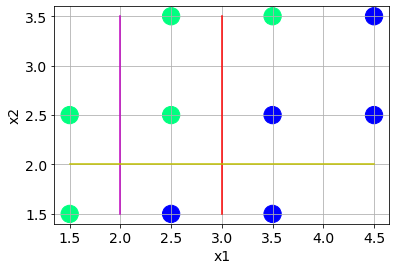

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

X = pd.DataFrame({'x1': [1.5, 1.5, 2.5, 2.5, 2.5, 3.5, 3.5, 3.5, 4.5, 4.5],
                  'x2': [1.5, 2.5, 1.5, 2.5, 3.5, 1.5, 2.5, 3.5, 2.5, 3.5]}) 
y = [1, 1, 0, 1, 1, 0, 0, 1, 0, 0]

plt.scatter('x1', 'x2', data=X, s=300, c=y, marker='o', cmap='winter')
plt.xlabel('x1')
plt.ylabel('x2')
plt.plot([3, 3], [1.5, 3.5], 'r-') # 1
plt.plot([2, 2], [1.5, 3.5], 'm-') # 2
plt.plot([1.5, 4.5], [2, 2], 'y-') # 3
plt.grid();

In [ ]:
import numpy as np

H_0 = - 5/10 * np.log2(5/10) - 5/10 * np.log2(5/10) # энтропия Шеннона
print('H_0 = {:.4}'.format(H_0))

# x_1 <= 2
H_left = - 2/2 * np.log2(2/2) - 0
print('H_left = {:.4}'.format(H_left))
H_right = - 3/8 * np.log2(3/8) - 5/8 * np.log2(5/8)
print('H_right = {:.4}'.format(H_right))
IG = H_0 - 2/10 * H_left - 8/10 * H_right # прирост информации
print('IG(x_1 <= 2.0) = {:.4}'.format(IG))

In [ ]:
# x_1 <= 3
print('H_0 = {:.4}'.format(H_0))
H_left = - 4/5 * np.log2(4/5) - 1/5 * np.log2(1/5)
print('H_left = {:.4}'.format(H_left))
H_right = - 1/5 * np.log2(1/5) - 4/5 * np.log2(4/5)
print('H_right = {:.4}'.format(H_right))
IG = H_0 - 5/10 * H_left - 5/10 * H_right
print('IG(x_1 <= 3.0) = {:.4}'.format(IG))

In [ ]:
# x_2 <= 2
print('H_0 = {:.4}'.format(H_0))
H_left = - 1/3 * np.log2(1/3) - 2/3 * np.log2(2/3)
print('H_left = {:.4}'.format(H_left))
H_right = - 4/7 * np.log2(4/7) - 3/7 * np.log2(3/7)
print('H_right = {:.4}'.format(H_right))
IG = H_0 - 3/10 * H_left - 7/10 * H_right
print('IG(x_2 <= 2.0) = {:.4}'.format(IG))

## Реализация дерева решений

Реализуем алгоритм алгоритм работы дерева решений своими руками.

In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [ ]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification( 
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, 
                                                      random_state=5)

In [ ]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [ ]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0 
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

Неопределенность Джини:
$$H(X) = 1 - \sum^{K}_{k=1}p_{k}^{2}.$$

In [ ]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

Энтропия классного чувака Шеннона:
$$H(X) = -\Sigma p(x)\log p(x).$$

In [ ]:
def entropy(labels, base=2):
    # Функция из Stackoverflow
    value,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()
    
    

Функционал качества:  

$$Q = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r})$$

In [ ]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [ ]:
def quality_1(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [ ]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [ ]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf = 5):
    
    #  обозначим минимальное количество объектов в узле
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [ ]:
def find_best_split_1(data, labels, min_leaf = 5):
    
    #  обозначим минимальное количество объектов в узле
    

    current_entropy = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality_1(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [ ]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, levels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or levels==0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, levels-1)
    false_branch = build_tree(false_data, false_labels, levels-1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [ ]:
# Построение дерева с помощью рекурсивной функции

def build_tree_1(data, labels, levels):

    quality, t, index = find_best_split_1(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or levels==0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_1(true_data, true_labels, levels-1)
    false_branch = build_tree_1(false_data, false_labels, levels-1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [ ]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [ ]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [ ]:
# Построим дерево по обучающей выборке
my_tree = build_tree_1(train_data, train_labels, 4)

In [ ]:
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

In [ ]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.prediction) 
                  + ', объектов = ' + str(len(node.labels)) 
                  + ColorText.END)
        return

    # Выведем значение индекса и порога на этом узле
    print(ColorText.GREEN + spacing + 'УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Левая ветка:')
    print_tree(node.true_branch, spacing + "   ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Правая ветка:')
    print_tree(node.false_branch, spacing + "   ")
    
print_tree(my_tree)

In [ ]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [ ]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

$$accuracy=\frac{1}{l}\sum^l_{i=1}[pred_i=y_i]$$

In [ ]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

In [ ]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

In [ ]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

Как видно, дерево строит кусочно-постоянную разделяющую гиперплоскость, то есть состоящую из прямых, параллельных осям. Чем глубже дерево, тем сложнее гиперплоскость. Также происходит и в случае регрессии - график зависимости целевого значения восстанавливается кусочно-постоянной функцией.

## Домашние задания

1. В коде из методички реализуйте один или несколько критериев останова: минимальное количество объектов в листе (`min_leaf`), максимальная глубина дерева, максимальное количество листьев и т.д. Добавьте эти критерии в параметры функции `build_tree` и проверьте ее работоспособность с помощью визуализации дерева (функция `print_tree()`). 
2. (\*) Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.
2. (\*) Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений. Проверьте точность предсказания дерева на одной из метрик задачи регрессии.

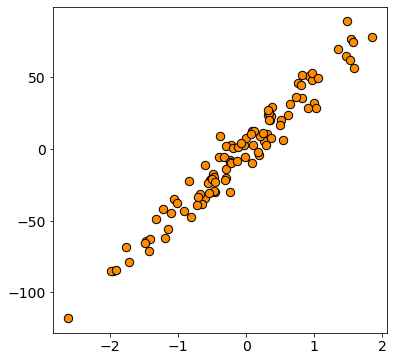

In [4]:
# 3 задание
from sklearn import datasets

regression_data, regression_labels = datasets.make_regression(n_samples=100, 
                                                      n_features=1, noise=10,
                                                      random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70);